In [24]:
import pyspark
import numpy as np
from pyspark import SparkContext, SparkConf
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = np.load('reduced_data.npy')

In [4]:
conf = SparkConf().setAppName("Prova").setMaster("local")
sc = SparkContext(conf=conf)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/09 09:36:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
points = list(zip(data[:,0], data[:,1]))
rdd = sc.parallelize(points)
cent = rdd.takeSample(withReplacement=False, num=3) # initial random centroid

22/12/09 09:37:05 WARN TaskSetManager: Stage 0 contains a task of very large size (2231 KiB). The maximum recommended task size is 1000 KiB.


22/12/09 09:37:07 WARN TaskSetManager: Stage 1 contains a task of very large size (2231 KiB). The maximum recommended task size is 1000 KiB.


In [6]:
def min_distance(x, c:list):
    x, c = np.array(x), np.array(c)
    dist = np.array(list(map(lambda a: np.linalg.norm(a - x)**2, c)))
    return np.argmin(dist)

In [7]:
def squared_distance(x, c:list):
    x, c = np.array(x), np.array(c)
    dist = np.array(list(map(lambda a: np.linalg.norm(a - x)**2, c)))
    return np.min(dist)

In [8]:
def k_means(rdd, cent):
    belong = rdd.map(lambda x: (min_distance(x, cent), x)) # which cluster each data belongs to
    return pd.DataFrame(belong.collect())
    
def centroids(rdd, cent):
    belong = rdd.map(lambda x: (min_distance(x, cent), x)) # which cluster each data belongs to
    count = belong.countByKey()
    summation = belong.reduceByKey(lambda x, y: (x[0]+y[0],  x[1]+y[1])) # pairwise summation over the values
    cent = summation.map(lambda x: (np.array(x[1])/ count[x[0]]))
    return cent.collect()

def var(rdd, cent):
    accum = sc.accumulator(0)
    rdd.map(lambda x: squared_distance(x, cent)).foreach(lambda x: accum.add(x))
    return accum.value

In [9]:
def iterating(k, rdd, threshold = 10):
    cent = rdd.takeSample(withReplacement=False, num=k) # initial random centroid    
    for i in range(20):
        prev_cent = cent
        cent = centroids(rdd, cent)
        distance = np.linalg.norm(np.array(prev_cent)-np.array(cent))
        if distance < threshold:
            break
    variance = var(rdd, cent)
    clusters = k_means(rdd, cent)
    return clusters, variance

In [10]:
sc.setLogLevel("OFF")
l = []
for k in tqdm(range(3, 11)):
    clusters, variance = iterating(k, rdd, threshold = 10)
    l.append(variance)

100%|██████████| 8/8 [17:20<00:00, 130.02s/it]                                  

[2.8013704395767514e+21, 2.1639205038995695e+21, 1.9774052834114567e+21, 1.8965096988825184e+21, 1.912837243607211e+21, 1.9054729160164982e+21, 1.8868865566411213e+21, 1.8916823609469572e+21]


<AxesSubplot:title={'center':'Elbow Method'}>

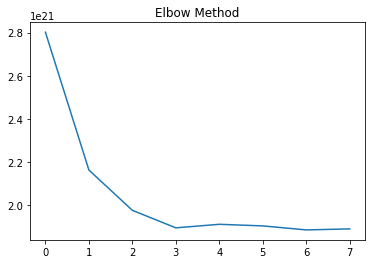

In [14]:
pd.DataFrame(l).plot(title = 'Elbow Method', legend = False)

k = 3

In [41]:
sc.setLogLevel("OFF")
clusters, variance = iterating(3, rdd, threshold = 10)

In [42]:
clusters['x'] = clusters[1].apply(lambda x: x[0])
clusters['y'] = clusters[1].apply(lambda x: x[1])
colors = ['#DF2020', '#81DF20', '#2095DF']
clusters['c'] = clusters[0].map({0:colors[0], 1:colors[1], 2:colors[2]})

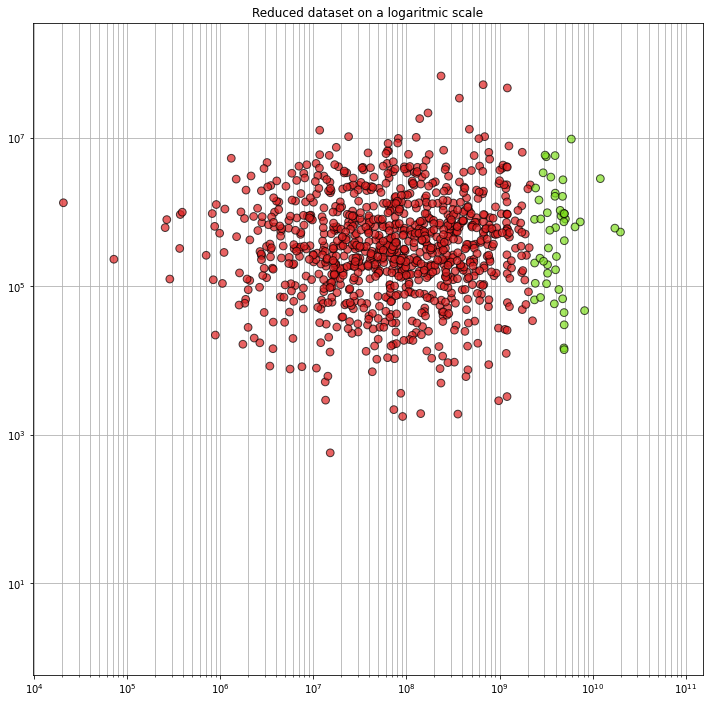

In [80]:
fig, ax = plt.subplots(figsize = (12,12))
plt.grid(True,zorder=0, which="both", ls="-")
ax.scatter(data[:,0], data[:,1], s=60, alpha=0.7, edgecolors="k", zorder=3, c=clusters.c)
plt.title("Reduced dataset on a logaritmic scale")
ax.set_yscale("log")
ax.set_xscale("log")

In [74]:
from sklearn.cluster import KMeans
kmeanspp = KMeans(n_clusters=3, init='k-means++').fit_predict(data)

In [79]:
sum(kmeanspp == 1)

4

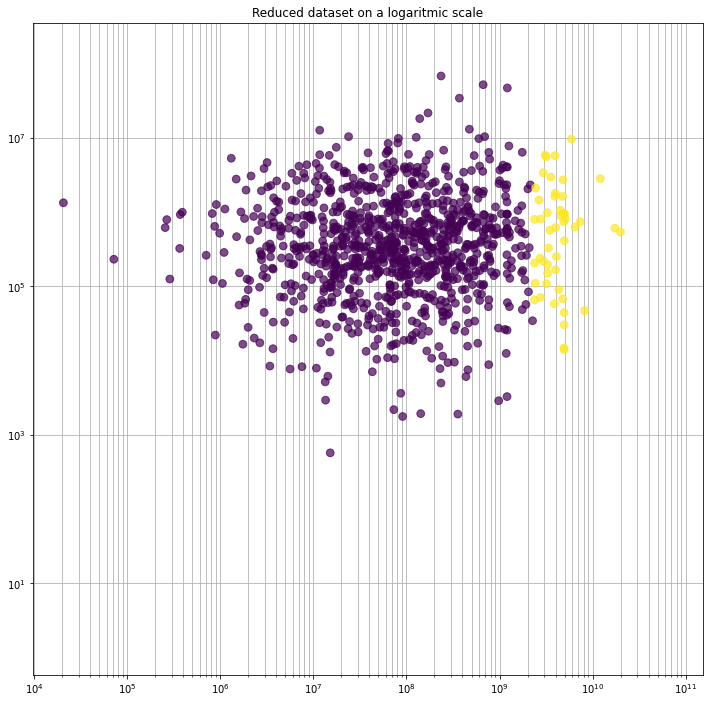

In [78]:
fig, ax = plt.subplots(figsize = (12,12))
plt.grid(True,zorder=0, which="both", ls="-")
ax.scatter(data[:,0], data[:,1], s=60, alpha=0.7, zorder=3, c=kmeanspp)
plt.title("Reduced dataset on a logaritmic scale")
ax.set_yscale("log")
ax.set_xscale("log")